In [3]:

import numpy as np
from PIL import Image
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,models
import torch.nn as nn
import torch
from PIL import Image
import glob
import torch
import clip
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import cv2


In [4]:
# Load the CLIP model
gpu_id = 1  # Change this to select a different GPU
device = f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu"

In [5]:
# Define transformations (data augmentation + normalization)
def get_transforms():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to ResNet-50 input size
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform

In [6]:
class CLIPDataset(Dataset):
    def __init__(self, image_paths, labels, transform, USE_DFT, USE_CROSS_DIFF):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.USE_DFT = USE_DFT
        self.USE_CROSS_DIFF = USE_CROSS_DIFF

    def __len__(self):
        return len(self.image_paths)

    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image_np = np.array(image)

        if self.USE_DFT:
            image_np = np.array(image)
            dft = np.fft.fft2(image_np, axes=(0, 1))
            dft_shifted = np.fft.fftshift(dft)
            magnitude_spectrum = 20 * np.log(np.abs(dft_shifted) + 1)
            image_np = np.uint8(np.clip(magnitude_spectrum, 0, 255))
            image = Image.fromarray(image_np.astype(np.uint8))

        if self.USE_CROSS_DIFF:
            image_np = np.array(image)
            blurred = cv2.GaussianBlur(image_np, (3, 3), 0)
            diff = cv2.absdiff(image_np, blurred)
            image = Image.fromarray(diff.astype(np.uint8))

        image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [7]:
# Define the file paths for training set
def get_dataset(transform, USE_DFT, USE_CROSS_DIFF):
    file_paths = [
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/ADM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/DDPM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/Diff-ProjectedGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/Diff-StyleGAN2/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/IDDPM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/LDM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/PNDM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/ProGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/ProjectedGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/StyleGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/Real/0_real/*.jpg'
    ]

    label_ADM = 0
    label_DDPM = 1
    label_Diff_Pro_GAN = 2
    label_Diff_Style_GAN = 3
    label_IDDPM = 4
    label_LDM = 5
    label_PNDM = 6
    label_ProGAN = 7
    label_ProjectedGAN = 8
    label_StyleGAN = 9
    label_Real = 10

    # List of labels
    labels = [label_ADM, label_DDPM, label_Diff_Pro_GAN, label_Diff_Style_GAN, label_IDDPM, label_LDM, label_PNDM, label_ProGAN, label_ProjectedGAN, label_StyleGAN, label_Real]


    # Collect all image paths and corresponding labels
    image_paths = []
    image_labels = []

    for path, label in zip(file_paths, labels):
        images = glob.glob(path)  # Get all image file paths in the folder
        image_paths.extend(images)
        image_labels.extend([label] * len(images))  # Assign the same label to all images in that folder

    # Check if images and labels are aligned
    assert len(image_paths) == len(image_labels)

    # Example usage
    dataset = CLIPDataset(image_paths, image_labels, transform, USE_DFT, USE_CROSS_DIFF)

    # Define the file paths for validation set
    # Define the file paths for training set
    val_file_paths = [
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/ADM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/DDPM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/Diff-ProjectedGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/Diff-StyleGAN2/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/IDDPM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/LDM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/PNDM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/ProGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/ProjectedGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/StyleGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/Real/0_real/*.jpg'
    ]

    label_ADM = 0
    label_DDPM = 1
    label_Diff_Pro_GAN = 2
    label_Diff_Style_GAN = 3
    label_IDDPM = 4
    label_LDM = 5
    label_PNDM = 6
    label_ProGAN = 7
    label_ProjectedGAN = 8
    label_StyleGAN = 9
    label_Real = 10

    # List of labels
    val_labels = [label_ADM, label_DDPM, label_Diff_Pro_GAN, label_Diff_Style_GAN, label_IDDPM, label_LDM, label_PNDM, label_ProGAN, label_ProjectedGAN, label_StyleGAN, label_Real]

    # Collect all image paths and corresponding labels
    val_image_paths = []
    val_image_labels = []

    for path, label in zip(val_file_paths, val_labels):
        images = glob.glob(path)  # Get all image file paths in the folder
        val_image_paths.extend(images)
        val_image_labels.extend([label] * len(images))

    # Check if images and labels are aligned
    assert len(val_image_paths) == len(val_image_labels)

    val_dataset = CLIPDataset(val_image_paths, val_image_labels, transform, USE_DFT, USE_CROSS_DIFF)

    return dataset, val_dataset



In [8]:
from collections import Counter
def checkDatapoints(dataset, val_dataset):
    label_idx_to_name = {
        0: "Picture of AI generated image, from ADM method",
        1: "Picture of AI generated image, from DDPM method",
        2: "Picture of AI generated image, from Diff-ProjectedGAN method",
        3: "Picture of AI generated image, from Diff-StyleGAN",
        4: "Picture of AI generated image, from IDDPM method",
        5: "Picture of AI generated image, from LDM method",
        6: "Picture of AI generated image, from PNDM method",
        7: "Picture of AI generated image, from ProGAN method",
        8: "Picture of AI generated image, from ProjectedGAN method",
        9: "Picture of AI generated image, from StyleGAN method",
        10: "Picture of a Real Image"
    }

    print(f"Number of datapoints per label in training set")
    label_counts = Counter(dataset.labels)
    for label, count in label_counts.items():
        print(f"{label_idx_to_name.get(label)}: {count} images")

    from collections import Counter
    print(f"Number of datapoints per label in validation set")
    label_counts = Counter(val_dataset.labels)
    for label, count in label_counts.items():
        print(f"{label_idx_to_name.get(label)}: {count} images")

In [9]:
# Load pretrained ResNet-50 model
class ResNet50MultiClassClassifier(nn.Module):
    def __init__(self, pretrained=True, num_classes=11):
        super(ResNet50MultiClassClassifier, self).__init__()
        self.model = models.resnet50(pretrained=pretrained)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)  # 11 classes (10 AI-generated types + 1 real image)

    def forward(self, x):
        return self.model(x)

In [10]:
class EarlyStopping:
    def __init__(self, model, patience=5, min_delta=0.001):
        """
        Args:
            patience (int): Number of epochs to wait after last improvement.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False
        self.model = model

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if loss improves
            self.model = model
        else:
            self.counter += 1  # Increase counter if no improvement
            if self.counter >= self.patience:
                self.early_stop = True


In [11]:
# Training Loop
def train_CNN(model, train_dummy_loader, val_dummy_loader, criterion, optimizer, num_epochs, breakpoint = 100):
    early_stopping = EarlyStopping(model,patience=3, min_delta=0.001)
    training_loss_list = []
    training_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_accuracy = 0
        for batch_idx, (images, labels) in enumerate(train_dummy_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            predicted = torch.argmax(outputs, dim=1)
            #Calcualte the accuracy
            accuracy = (predicted == labels).sum().item() / len(labels)
            total_accuracy += accuracy
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            training_loss_list.append(loss.item())
            training_accuracy_list.append(accuracy)
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dummy_loader)}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}", end='\r')
            break
            if batch_idx > breakpoint:
                break
        avg_loss = total_loss /( batch_idx+1)
        avg_accuracy = total_accuracy / (batch_idx+1)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}", end='\r')

        # Validation 
        model.eval()
        with torch.no_grad():
            total_loss = 0.0
            total_accuracy = 0.0
            for val_idx, (images, labels) in enumerate(val_dummy_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss
                predicted = torch.argmax(outputs, dim=1)
                #Calcualte the accuracy
                accuracy = (predicted == labels).sum().item() / len(labels)
                total_accuracy += accuracy
                val_loss_list.append(loss.item())
                val_accuracy_list.append(accuracy)
                break
                if val_idx > breakpoint:
                    break
            avg_loss = total_loss / (val_idx+1)
            avg_accuracy = total_accuracy / (val_idx+1)
            early_stopping(avg_loss, model)
            print(f"\nValidation Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}\n", end='\r')
            
            if early_stopping.early_stop:
                print("Early stopping triggered!")
                break
    return training_accuracy_list, training_loss_list, val_loss_list, val_accuracy_list, early_stopping.model


In [12]:
def plotFig(train_loss, val_loss, name):
  #Plot the training and validation loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    path = '/data/home/saisuchithm/godwin/mlsp/project'
    location = path + name + '.png'
    plt.savefig(location)
    plt.show()

In [18]:
# Initialize model, loss function, and optimizer
model = ResNet50MultiClassClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay = 1e-5)
transform = get_transforms()
dataset, val_dataset = get_dataset(transform, USE_DFT=True, USE_CROSS_DIFF=False)

#Define the dataloaders
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

model_name = 'CNN_AI_Detect'
print(f"Start Training the model")
training_accuracy_list, training_loss_list, val_loss_list, val_accuracy_list, model = train_CNN(model=model,
                                                                                                train_dummy_loader=train_dataloader,
                                                                                                val_dummy_loader=val_dataloader,
                                                                                                criterion=criterion,
                                                                                                optimizer=optimizer,
                                                                                                num_epochs=1)

print("Dummy training and validation completed successfully!")
# plotFig(train_loss=training_loss_list, val_loss=val_loss_list, name="CNN_Loss")
# plotFig(train_loss=training_accuracy_list, val_loss=val_accuracy_list, name="CNN_Accuracy")


# # Save model
# torch.save(model.state_dict(), "resnet50_ai_vs_real_11class.pth")
# print("Model saved successfully!")

Start Training the model
Epoch 1/1, Average Loss: 2.3082, Average Accuracy: 0.1250250
Validation Loss: 2.2943, Accuracy: 0.0000
Dummy training and validation completed successfully!


In [ ]:
del model
del criterion
del optimizer
del train_dataloader
del val_dataloader 


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()



### Testing on the Validation dataset for each class

In [13]:
label_idx_to_name = {
        0: "Picture of AI generated image, from ADM method",
        1: "Picture of AI generated image, from DDPM method",
        2: "Picture of AI generated image, from Diff-ProjectedGAN method",
        3: "Picture of AI generated image, from Diff-StyleGAN",
        4: "Picture of AI generated image, from IDDPM method",
        5: "Picture of AI generated image, from LDM method",
        6: "Picture of AI generated image, from PNDM method",
        7: "Picture of AI generated image, from ProGAN method",
        8: "Picture of AI generated image, from ProjectedGAN method",
        9: "Picture of AI generated image, from StyleGAN method",
        10: "Picture of a Real Image"
    }

#### For the CNN trained on Normal Images

In [ ]:
model = ResNet50MultiClassClassifier().to(device)
model.load_state_dict(torch.load("/data/home/saisuchithm/godwin/mlsp/project/MLSP_CNN.pth", weights_only=True))
model.eval()

In [143]:
accuracy_class = []
for i in range(11):
    first_index = i*1000
    last_index = (i+1)*1000
    accuracy = 0
    for j in range(first_index, last_index):
      image = val_dataset[j][0]
      label = val_dataset[j][1]
      image = image.unsqueeze(0)
      image = image.to(device)
      label = torch.tensor([label]).to(device)
      output = model(image)
      predicted = torch.argmax(output, dim=1)
      if predicted == label:
        accuracy += 1
    accuracy_class.append(accuracy/1000)
print(accuracy_class)

[0.896, 0.994, 0.948, 0.969, 0.837, 0.967, 0.985, 0.998, 0.931, 0.982, 0.977]


In [149]:
for i in range(len(accuracy_class)):
    print(f"{label_idx_to_name.get(i)} has accuracy of {accuracy_class[i]}")

Picture of AI generated image, from ADM method has accuracy of 0.896
Picture of AI generated image, from DDPM method has accuracy of 0.994
Picture of AI generated image, from Diff-ProjectedGAN method has accuracy of 0.948
Picture of AI generated image, from Diff-StyleGAN has accuracy of 0.969
Picture of AI generated image, from IDDPM method has accuracy of 0.837
Picture of AI generated image, from LDM method has accuracy of 0.967
Picture of AI generated image, from PNDM method has accuracy of 0.985
Picture of AI generated image, from ProGAN method has accuracy of 0.998
Picture of AI generated image, from ProjectedGAN method has accuracy of 0.931
Picture of AI generated image, from StyleGAN method has accuracy of 0.982
Picture of a Real Image has accuracy of 0.977


### For the CNN trained on DFTed Images

In [12]:
model = ResNet50MultiClassClassifier().to(device)
model.load_state_dict(torch.load("/data/home/saisuchithm/godwin/mlsp/project/MLSP_CNN_DFT.pth", weights_only=True))
model.eval()
transform = get_transforms()
_, val_dataset = get_dataset(transform, USE_DFT=True, USE_CROSS_DIFF=False)

/data/home/saisuchithm/python-envs/ai-gen-detect/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/home/saisuchithm/python-envs/ai-gen-detect/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
accuracy_class = []
for i in range(11):
    first_index = i*1000
    last_index = (i+1)*1000
    accuracy = 0
    for j in range(first_index, last_index):
      image = val_dataset[j][0]
      label = val_dataset[j][1]
      image = image.unsqueeze(0)
      image = image.to(device)
      label = torch.tensor([label]).to(device)
      output = model(image)
      predicted = torch.argmax(output, dim=1)
      if predicted == label:
        accuracy += 1
    accuracy_class.append(accuracy/1000)
print(accuracy_class)

[0.592, 0.994, 0.998, 1.0, 0.818, 0.999, 1.0, 0.996, 0.996, 0.993, 0.974]


In [15]:
for i in range(len(accuracy_class)):
    print(f"{label_idx_to_name.get(i)} has accuracy of {accuracy_class[i]}")

Picture of AI generated image, from ADM method has accuracy of 0.592
Picture of AI generated image, from DDPM method has accuracy of 0.994
Picture of AI generated image, from Diff-ProjectedGAN method has accuracy of 0.998
Picture of AI generated image, from Diff-StyleGAN has accuracy of 1.0
Picture of AI generated image, from IDDPM method has accuracy of 0.818
Picture of AI generated image, from LDM method has accuracy of 0.999
Picture of AI generated image, from PNDM method has accuracy of 1.0
Picture of AI generated image, from ProGAN method has accuracy of 0.996
Picture of AI generated image, from ProjectedGAN method has accuracy of 0.996
Picture of AI generated image, from StyleGAN method has accuracy of 0.993
Picture of a Real Image has accuracy of 0.974


### GradCam 
Define a class to store and analyse the gradients

In [13]:
class GradCam:
  def __init__(self, model, target_layer):
    super(GradCam, self).__init__()
    self.model = model
    self.target_layer = target_layer
    self.gradients = None
    self.activations = None

    #Register the hooks 
    self.target_layer.register_forward_hook(self.forward_hook)
    self.target_layer.register_full_backward_hook(self.backward_hook)
  
  def forward_hook(self, module, input, output):
    self.activations = output
  
  def backward_hook(self, module, grad_in, grad_out):
    self.gradients = grad_out[0]

  def generate(self, input, target):
    self.model.zero_grad()
    output = self.model(input)
    loss = output[0, target]

    loss.backward()

    activations = self.activations.detach()
    gradients = self.gradients.detach()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.size(1)):
      activations[:, i, :, :] *= pooled_gradients[i]
    # weighted_activations = self.activations[0] * pooled_gradients[:, None, None]

    cam = torch.mean(activations, dim=1).squeeze().cpu()
    cam = np.maximum(cam, 0)
    cam -= cam.min()
    cam /= torch.max(cam)
    return cam.cpu().numpy()

In [6]:
import numpy as np
arr = np.array([[1, 2, 3],[4, 5, 6]])
# np.mean(arr, axis=0)
arr.shape, np.mean(arr, axis=0).shape, np.mean(arr, axis=1).shape


((2, 3), (3,), (2,))

In [61]:
# Helper to overlay heatmap
def overlay_cam_on_image(img_pil, cam, alpha=0.5):
    img_np = np.array(img_pil)  

    # Make sure cam is normalized and resized to image dimensions
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[2]))
    cam_normalized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_normalized), cv2.COLORMAP_JET)

    # Convert heatmap to float for blending
    heatmap = np.float32(heatmap) / 255.0
    # img_np = np.float32(img_np) / 255.0

    # Blend heatmap and image
    overlay = alpha * heatmap + (1 - alpha) * img_np.T
    # overlay = np.clip(overlay, 0, 1)
    overlay = np.uint8(255 * overlay)
    return overlay

In [62]:
model = ResNet50MultiClassClassifier().to(device)
model.load_state_dict(torch.load("/data/home/saisuchithm/godwin/mlsp/project/MLSP_CNN.pth", weights_only=True))
model.eval()

/data/home/saisuchithm/python-envs/ai-gen-detect/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/home/saisuchithm/python-envs/ai-gen-detect/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50MultiClassClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

In [63]:
target_layer = model.model.layer4[-1]
#Define Gradcam object with the model and target layer
grad_cam = GradCam(model, target_layer)
transform = get_transforms()
dataset, val_dataset = get_dataset(transform, USE_DFT=False, USE_CROSS_DIFF=False)

image = val_dataset[3500][0].to(device)
label = val_dataset[3500][1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


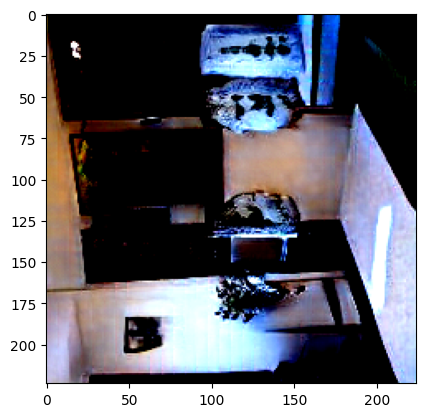

In [64]:
plt.imshow(image.cpu().T)


In [65]:
cam = grad_cam.generate(image.unsqueeze(0), label)

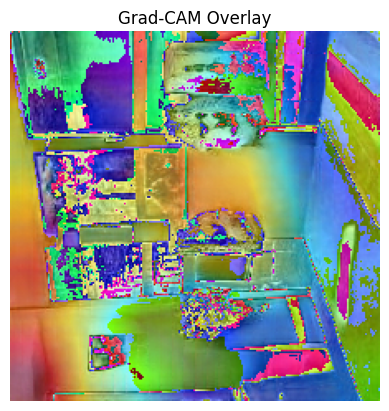

In [68]:
overlay = overlay_cam_on_image(image.cpu(), cam, alpha=0.5)

plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis("off")
plt.show()

In [59]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def overlay_cam_on_image(img_pil, cam, alpha=0.5):
    img_np = np.array(image.cpu().T)

    # Resize cam to image size
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    cam_normalized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)
    
    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_normalized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255.0
    # img_np = np.float32(img_np) / 255.0

    # Overlay
    overlay = alpha * heatmap + (1 - alpha) * img_np
    overlay = np.uint8(255 * overlay)
    
    return overlay, heatmap, img_np

def plot_side_by_side(img_np, heatmap, overlay):
    plt.figure(figsize=(18, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.axis('off')
    plt.title('Original Image')

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title('Heatmap')

    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title('Overlayed Image')

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


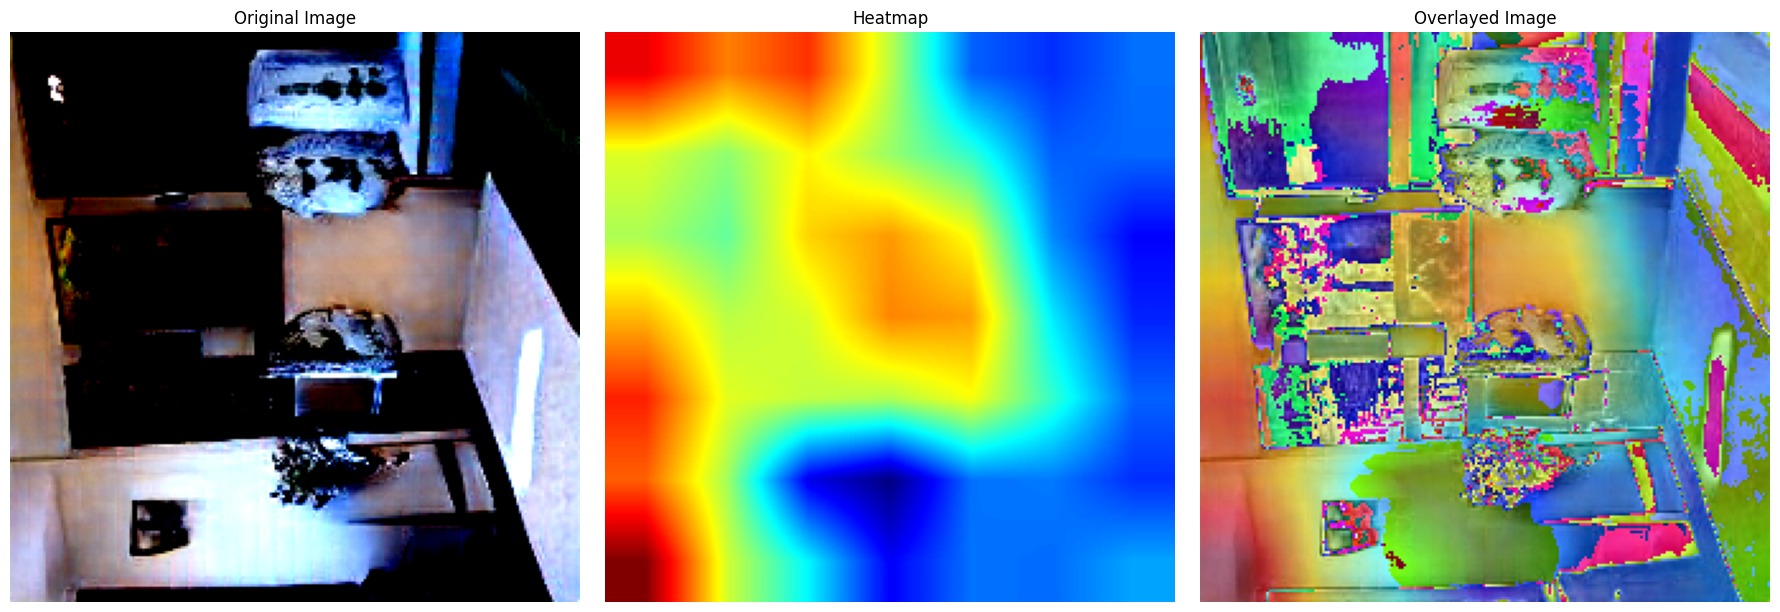

In [60]:
# Call your overlay function
overlay, heatmap, img_np = overlay_cam_on_image(image, cam)

# Plot all 3 side by side
plot_side_by_side(img_np, heatmap, overlay)

